---
title: "Structure plot from GWAS phenotypes"
author: "Saikat Banerjee"
format:
  html: default
date: "2023-10-16"
file-modified: "2023-10-16"
abstract: "Our goal is to create a structure plot from the PCA. 
We obtain low rank approximation of the GWAS summary statistics data using the three methods we have developed till date.
We manually label each GWAS with a broad phenotype. 
We perform PCA on the approximated low rank matrix and analyze the clustering of the data 
by comparing with the curated phenotype labels."

---

# Getting Setup

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 120, colors = 'kelly')

from nnwmf.optimize import IALM
from nnwmf.optimize import FrankWolfe, FrankWolfe_CV
from nnwmf.utils import model_errors as merr

import sys
sys.path.append("../utils/")
import histogram as mpy_histogram
import simulate as mpy_simulate
import plot_functions as mpy_plotfn

# Loading data

In [2]:
data_dir = "../data"
beta_df_filename   = f"{data_dir}/beta_df.pkl"
prec_df_filename   = f"{data_dir}/prec_df.pkl"
se_df_filename     = f"{data_dir}/se_df.pkl"
zscore_df_filename = f"{data_dir}/zscore_df.pkl"

'''
Data Frames for beta, precision, standard error and zscore.
'''

beta_df   = pd.read_pickle(beta_df_filename)
prec_df   = pd.read_pickle(prec_df_filename)
se_df     = pd.read_pickle(se_df_filename)
zscore_df = pd.read_pickle(zscore_df_filename)

trait_df = pd.read_csv(f"{data_dir}/trait_meta.csv")
phenotype_dict = trait_df.set_index('ID')['Broad'].to_dict()

In [3]:
zscore_df

,AD_sumstats_Jansenetal_2019sept.txt.gz,CNCR_Insomnia_all,GPC-NEO-NEUROTICISM,IGAP_Alzheimer,Jones_et_al_2016_Chronotype,Jones_et_al_2016_SleepDuration,MDD_MHQ_BIP_METACARPA_INFO6_A5_NTOT_no23andMe_...,MDD_MHQ_METACARPA_INFO6_A5_NTOT_no23andMe_noUK...,MHQ_Depression_WG_MAF1_INFO4_HRC_Only_Filtered...,MHQ_Recurrent_Depression_WG_MAF1_INFO4_HRC_Onl...,...,ieu-b-7,ieu-b-8,ieu-b-9,ocd_aug2017.txt.gz,pgc-bip2021-BDI.vcf.txt.gz,pgc-bip2021-BDII.vcf.txt.gz,pgc-bip2021-all.vcf.txt.gz,pgc.scz2,pgcAN2.2019-07.vcf.txt.gz,pts_all_freeze2_overall.txt.gz
rs1000031,-0.999531,-0.327477,1.241557,0.441709,-0.163658,0.163658,-0.336654,-0.793129,-1.075357,-2.182304,...,0.532189,NaN,NaN,-0.198735,1.057089,-0.269020,1.279776,-0.433158,-1.573766,-1.674269
rs1000269,-1.212805,-1.046310,0.741814,-1.844296,-2.673787,-1.126391,0.092067,0.163246,1.643581,2.122280,...,1.665179,-0.732000,-0.699000,0.100883,-0.226381,0.338368,-0.924392,0.832016,0.681645,-0.701776
rs10003281,-0.813444,2.034345,-1.750164,-0.076778,-0.954165,1.805477,NaN,NaN,NaN,NaN,...,-0.475795,4.437998,2.366001,0.967399,0.286699,-1.162661,-0.199299,0.014539,NaN,-1.379710
rs10004866,0.011252,1.327108,1.442363,-1.215173,-0.050154,-1.439531,2.458370,2.407460,-0.001038,-1.678331,...,-1.234375,-2.520001,-0.593997,-0.685110,0.902252,1.106939,1.776456,-1.654677,-0.964630,0.851608
rs10005235,0.612540,-0.410609,0.653087,0.344062,-2.183486,1.514102,-0.460191,-0.393006,1.015614,0.180744,...,0.387805,-0.345000,-0.960998,0.177317,-1.339598,1.795867,-1.249969,2.349671,0.996305,-0.333356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
rs9989571,0.028306,-0.208891,0.366470,0.821257,0.453762,-1.895698,0.218149,0.920789,1.581000,1.121551,...,-1.231511,-0.820996,0.712000,-2.150176,-0.877410,-1.938969,-2.729983,3.207917,1.469194,-1.293122
rs9991694,-0.679790,-1.005571,0.753472,-0.539271,1.674665,-2.862736,-3.744820,-3.583060,-4.072853,-2.804192,...,0.064417,NaN,NaN,-2.884911,-1.000231,0.031860,-1.248222,2.309425,NaN,1.048454
rs9992763,0.691405,-0.010299,-0.140010,-0.419843,-0.138304,0.568052,0.019684,-0.194404,0.869694,0.061210,...,0.191860,-0.074000,1.030997,-0.228287,-0.051297,0.781766,0.010638,0.456681,-0.503370,-1.435277
rs9993607,-1.625392,-0.391585,0.514268,0.027576,0.150969,-0.113039,-4.638940,-4.631950,-2.918354,-2.204015,...,-0.685106,0.194000,0.240001,-0.790290,-0.876804,-0.577696,-0.785670,-0.062707,0.240834,-0.199740


In [4]:
#| code-fold: false

X_nan = np.array(zscore_df).T
X_nan_cent = X_nan - np.nanmean(X_nan, axis = 0, keepdims = True)
X_nan_mask = np.isnan(X_nan)
X_cent = np.nan_to_num(X_nan_cent, copy = True, nan = 0.0)

print (f"We have {X_cent.shape[0]} samples (phenotypes) and {X_cent.shape[1]} features (variants)")
print (f"Fraction of Nan entries: {np.sum(X_nan_mask) / np.prod(X_cent.shape):.3f}")

We have 69 samples (phenotypes) and 10068 features (variants)
Fraction of Nan entries: 0.193


In [5]:
#| code-fold: false

select_ids = zscore_df.columns
labels = [phenotype_dict[x] for x in select_ids]
unique_labels = list(set(labels))
nsample = X_cent.shape[0]
ntrait  = len(unique_labels)

trait_indices = [np.array([i for i, x in enumerate(labels) if x == label]) for label in unique_labels]
trait_colors  = {trait: color for trait, color in zip(unique_labels, (mpl_stylesheet.kelly_colors())[:ntrait])}

We perform PCA (using SVD) on the raw input data (mean centered). In @fig-input-pca-pve, we look at the proportion of variance explained by each principal component. 

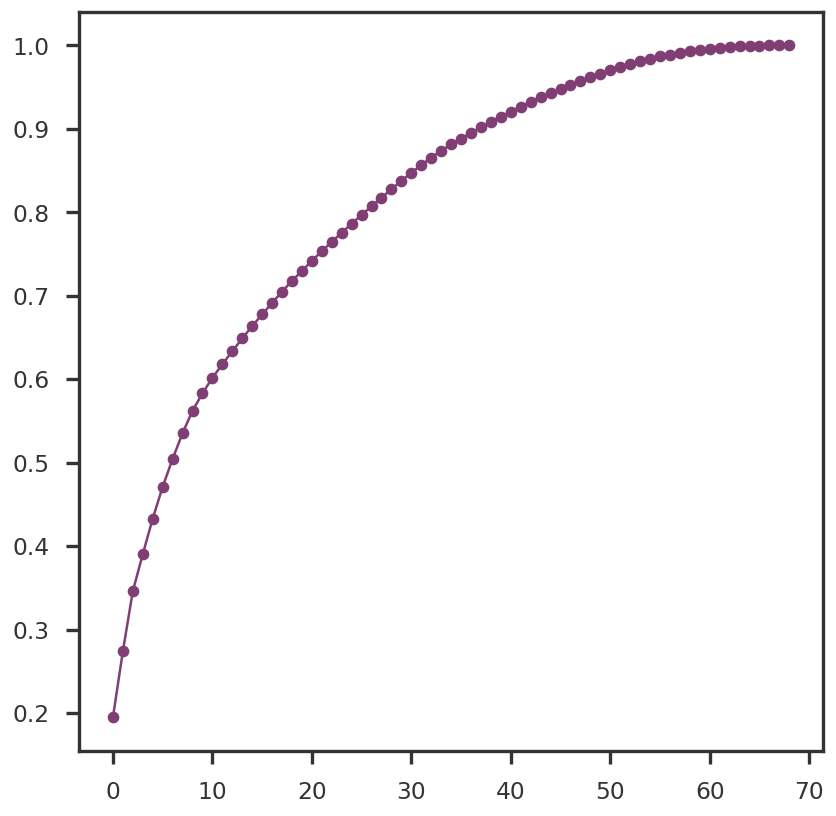

In [6]:
#| label: fig-input-pca-pve
#| fig-cap: "Proportion of variance explained by the principal components of the input matrix"

U, S, Vt = np.linalg.svd(X_cent, full_matrices = False)
S2 = np.square(S)
pcomp = U @ np.diag(S)

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(np.arange(S.shape[0]), np.cumsum(S2 / np.sum(S2)), 'o-')
plt.show()

In @fig-trait-wise-pve-pc1-input-data, we look at the proportion of variance for each trait explained by the first principal component. Traits in the same "broad category" are combined together to show the histogram (boxplot).

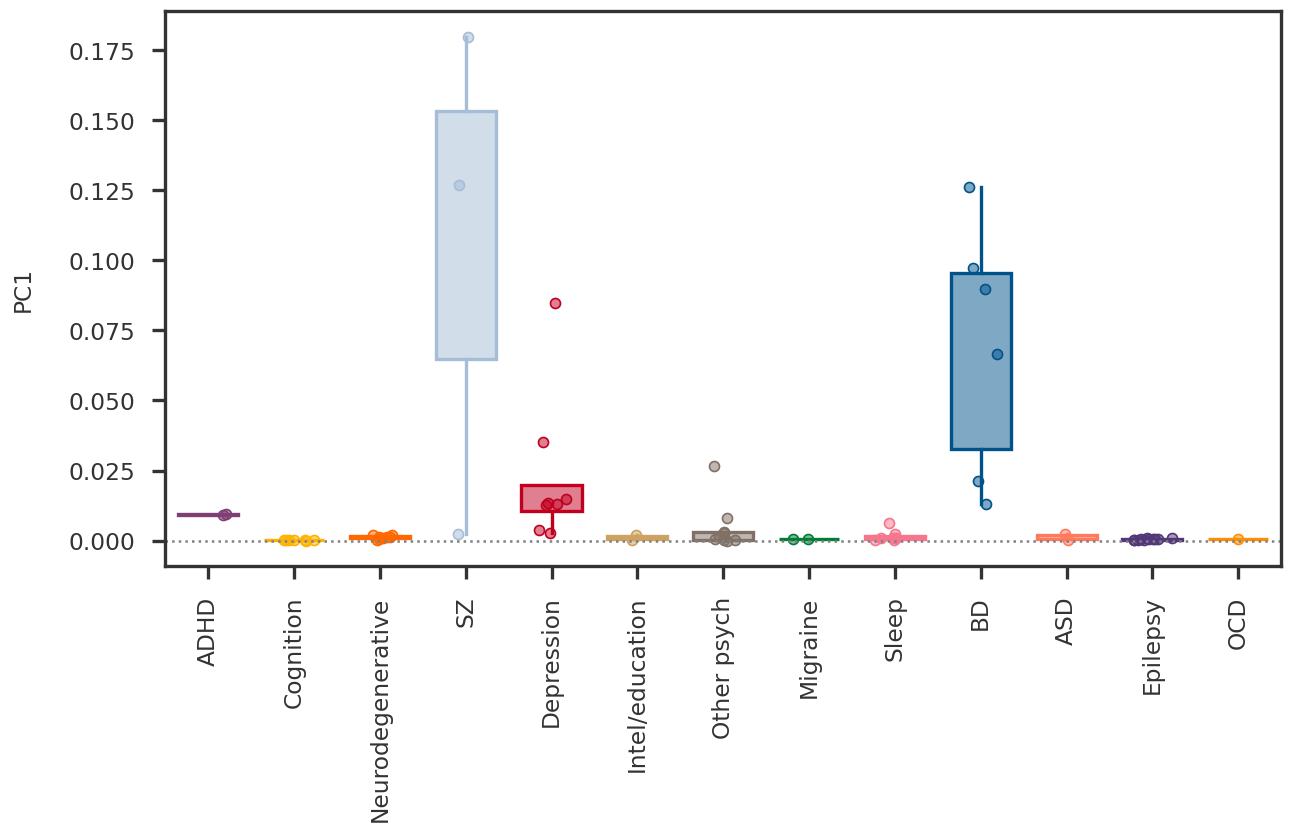

In [7]:
#| label: fig-trait-wise-pve-pc1-input-data
#| fig-cap: "Trait-wise PVE by the first principal component of the input matrix"

fig = plt.figure(figsize = (12, 6))
ax1 = fig.add_subplot(111)


pcidx = 0
tot_variance  = S2[pcidx]
trait_scores  = [np.square(pcomp[idx, pcidx]) / tot_variance for idx in trait_indices]

def rand_jitter(n, d = 0.1):
    return np.random.randn(n) * d

for ilbl, label in enumerate(unique_labels):
    xtrait = trait_scores[ilbl]
    nsample = xtrait.shape[0]
    
    boxcolor = trait_colors[label]
    boxface = f'#{boxcolor[1:]}80' #https://stackoverflow.com/questions/15852122/hex-transparency-in-colors
    medianprops = dict(linewidth=0, color = boxcolor)
    whiskerprops = dict(linewidth=2, color = boxcolor)
    boxprops = dict(linewidth=2, color = boxcolor, facecolor = boxface)
    flierprops = dict(marker='o', markerfacecolor=boxface, markersize=3, markeredgecolor = boxcolor)
    
    ax1.boxplot(xtrait, positions = [ilbl],
                showcaps = False, showfliers = False,
                widths = 0.7, patch_artist = True, notch = False,
                flierprops = flierprops, boxprops = boxprops,
                medianprops = medianprops, whiskerprops = whiskerprops)
    
    ax1.scatter(ilbl + rand_jitter(nsample), xtrait, edgecolor = boxcolor, facecolor = boxface, linewidths = 1)


ax1.axhline(y = 0, ls = 'dotted', color = 'grey')
ax1.set_xticks(np.arange(len(unique_labels)))
ax1.set_xticklabels(unique_labels, rotation = 90)
ax1.set_ylabel(f"PC{pcidx + 1:d}")

plt.show()

In [8]:
def plot_stacked_bars(ax, data, xlabels, colors, bar_width = 1.0, alpha = 1.0):
    '''
    Parameters
    ----------
        data: 
            dict() of scores. 
            - <key> : items for the stacked bars (e.g. traits)
            - <value> : list of scores for the items. All dict entries must have the same length of <value>
        xlabels: 
            label for each entry in the data <value> list. Must be of same length of data <value>
        colors: 
            dict(<key>, <color>) corresponding to each data <key>.
    '''
    indices = np.arange(len(xlabels))
    bottom = np.zeros(len(xlabels))

    for item, weights in data.items():
        ax.bar(indices, weights, bar_width, label = item, bottom = bottom, color = colors[item], alpha = alpha)
        bottom += weights

    ax.set_xticks(indices)
    ax.set_xticklabels(xlabels)

    for side, border in ax.spines.items():
        border.set_visible(False)

    ax.tick_params(bottom = True, top = False, left = False, right = False,
                   labelbottom = True, labeltop = False, labelleft = False, labelright = False)
    
    return

def get_trait_pc_scores(U, S, tindices, ulabels, min_idx = 0, max_idx = 20, use_proportion = False):
    '''
    Prepare data for stacked bars
    Parameters
    ----------
        U: left singular vectors
        S: singular values
        tindices: [np.array(<index of samples in class>)], length = number-of-classes
        ulabels: name of classes, length = number-of-classes
    '''
    scores = dict()
    pcindices = np.arange(min_idx, max_idx)
    pcomp = U @ np.diag(S)
    S2 = np.square(S)
    
    for pcidx in pcindices:
        scores[pcidx] = [np.square(pcomp[idx, pcidx]) for idx in tindices]
        if use_proportion:
            scores[pcidx] = [x / S2[pcidx] for x in scores[pcidx]]# divide by total variance
            
    # Create data for input to stacked bars
    data = {trait: [np.sum(scores[idx][ilbl]) for idx in pcindices] for ilbl, trait in enumerate(ulabels)}
            
    return data

def quick_plot_trait_pc_scores(X, tindices, ulabels, tcolors, min_idx = 0, max_idx = 20):
    '''
    Quick helper function to plot the same thing many times
    '''
    X_cent = mpy_simulate.do_standardize(X, scale = False)
    U, S, Vt = np.linalg.svd(X_cent, full_matrices = False)
    
    data = get_trait_pc_scores(U, S, tindices, ulabels, min_idx = min_idx, max_idx = max_idx, use_proportion = False)
    data_scaled = get_trait_pc_scores(U, S, tindices, ulabels, min_idx = min_idx, max_idx = max_idx, use_proportion = True)
    xlabels = [f"{i + 1}" for i in np.arange(min_idx, max_idx)]

    fig = plt.figure(figsize = (12, 10))
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    plot_stacked_bars(ax1, data, xlabels, tcolors, alpha = 0.8)
    plot_stacked_bars(ax2, data_scaled, xlabels, tcolors, alpha = 0.8)

    ax1.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

    ax2.set_xlabel("Principal Components")
    ax1.set_ylabel("Trait-wise scores for each PC")
    ax2.set_ylabel("Trait-wise scores for each PC (scaled)")
    plt.tight_layout(h_pad = 2.0)
    plt.show()
    return

In @fig-trait-wise-pca-score-input-data, we stack the variance score of each disease category for each principal component. Components explaining majority of the same disease are able to distinguish the corresponding disease.

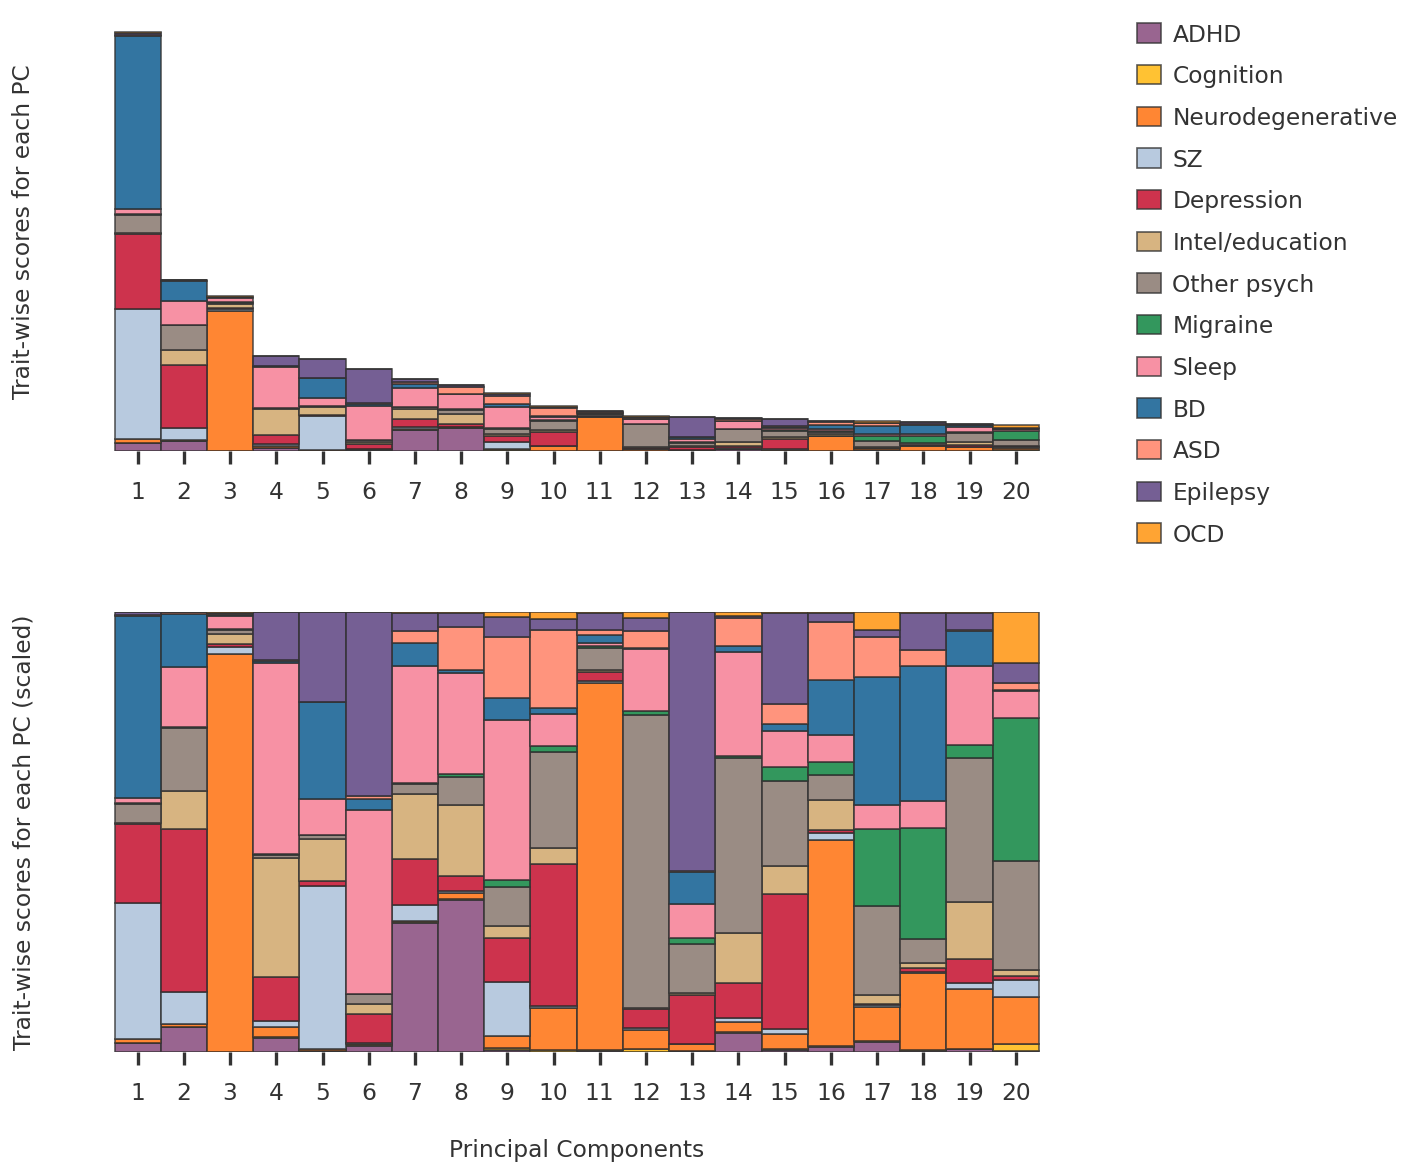

In [9]:
#| label: fig-trait-wise-pca-score-input-data
#| fig-cap: "Trait-wise PVE for the first 20 principal components of the input matrix"

quick_plot_trait_pc_scores(X_cent, trait_indices, unique_labels, trait_colors)

# Denoising methods

## IALM - RPCA

In [10]:
rpca = IALM(max_iter = 1000, mu_update_method='admm', show_progress = True)
rpca.fit(X_cent, mask = X_nan_mask)

2023-10-16 13:22:19,806 | nnwmf.optimize.inexact_alm               | DEBUG   | Fit RPCA using IALM (mu update admm, lamba = 0.0100)
2023-10-16 13:22:19,983 | nnwmf.optimize.inexact_alm               | INFO    | Iteration 0. Primal residual 0.893741. Dual residual 0.000574896
2023-10-16 13:22:27,345 | nnwmf.optimize.inexact_alm               | INFO    | Iteration 100. Primal residual 6.36112e-05. Dual residual 2.55942e-05
2023-10-16 13:22:34,631 | nnwmf.optimize.inexact_alm               | INFO    | Iteration 200. Primal residual 2.26287e-05. Dual residual 2.64972e-06
2023-10-16 13:22:41,962 | nnwmf.optimize.inexact_alm               | INFO    | Iteration 300. Primal residual 6.03351e-06. Dual residual 1.69738e-06
2023-10-16 13:22:49,261 | nnwmf.optimize.inexact_alm               | INFO    | Iteration 400. Primal residual 4.08978e-06. Dual residual 8.33885e-07
2023-10-16 13:22:56,544 | nnwmf.optimize.inexact_alm               | INFO    | Iteration 500. Primal residual 3.12383e-06. Dual 

In [11]:
np.linalg.matrix_rank(rpca.L_)

50

In [12]:
np.linalg.norm(rpca.L_, 'nuc')

1351.848015043226

In [13]:
np.sum(np.abs(rpca.E_)) / np.prod(X_cent.shape)

0.5906261807412263

## FW - NNM 

Also check how the cross-validation works

In [14]:
nnmcv = FrankWolfe_CV(chain_init = True, reverse_path = False, debug = True, kfolds = 5)
nnmcv.fit(X_nan_cent)

2023-08-08 23:54:07,309 | nnwmf.optimize.frankwolfe_cv             | DEBUG   | Cross-validation over 14 ranks.
2023-08-08 23:54:07,338 | nnwmf.optimize.frankwolfe_cv             | DEBUG   | Fold 1 ...
2023-08-08 23:54:07,359 | nnwmf.optimize.frankwolfe_cv             | DEBUG   | Rank 1.0000
2023-08-08 23:54:09,099 | nnwmf.optimize.frankwolfe_cv             | DEBUG   | Rank 2.0000
2023-08-08 23:54:10,281 | nnwmf.optimize.frankwolfe_cv             | DEBUG   | Rank 4.0000
2023-08-08 23:54:14,327 | nnwmf.optimize.frankwolfe_cv             | DEBUG   | Rank 8.0000
2023-08-08 23:54:15,509 | nnwmf.optimize.frankwolfe_cv             | DEBUG   | Rank 16.0000
2023-08-08 23:54:17,192 | nnwmf.optimize.frankwolfe_cv             | DEBUG   | Rank 32.0000
2023-08-08 23:54:21,295 | nnwmf.optimize.frankwolfe_cv             | DEBUG   | Rank 64.0000
2023-08-08 23:54:40,008 | nnwmf.optimize.frankwolfe_cv             | DEBUG   | Rank 128.0000
2023-08-08 23:55:00,369 | nnwmf.optimize.frankwolfe_cv            

We do a 5-fold cross-validation. We randomly mask a part of the data and apply our method to recover the masked data. The test error is the RMSE between the receovered data and input masked data. 
In @fig-nnm-cv, we plot the RMSE of the test data for each CV fold.

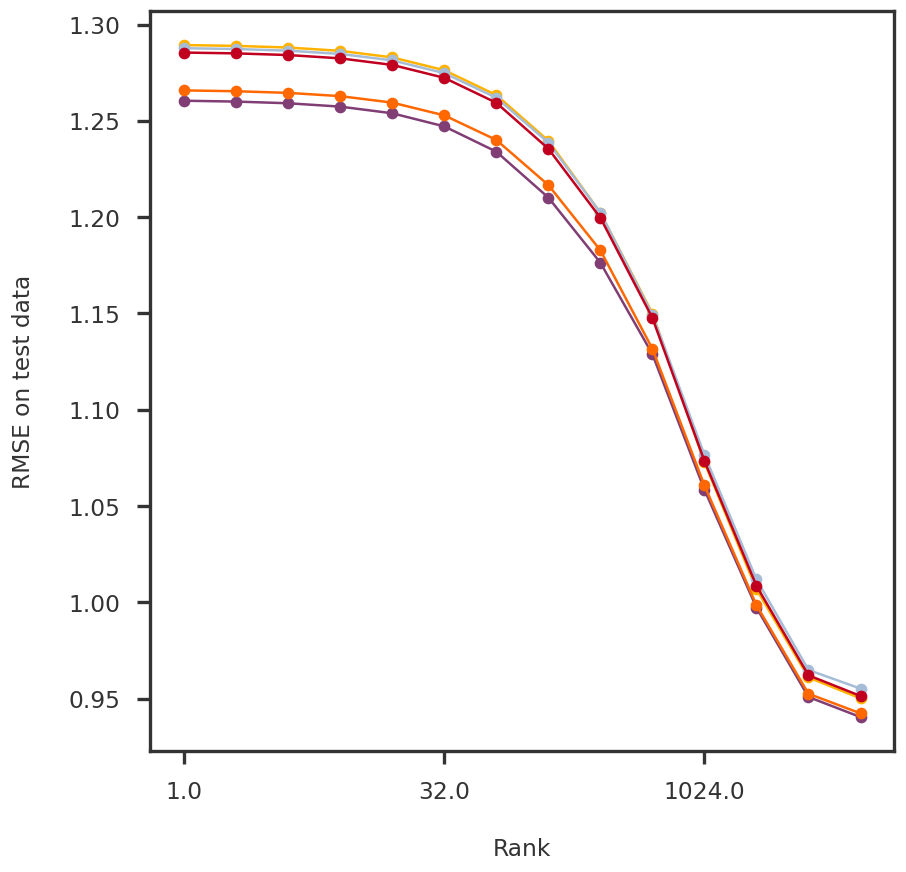

In [53]:
#| label: fig-nnm-cv
#| fig-cap: "Error on held out test data for each of the 5-fold cross-validation sets to find the best rank constraint for NNM"

fig = plt.figure()
ax1 = fig.add_subplot(111)
for k in range(5):
    ax1.plot(np.log10(list(nnmcv.test_error.keys())), [x[k] for x in nnmcv.test_error.values()], 'o-')
ax1.set_xlabel("Rank")
ax1.set_ylabel("RMSE on test data")
mpl_utils.set_xticks(ax1, scale = 'log10', spacing = 'log2')
plt.show()

In [14]:
np.linalg.norm(X_cent, 'nuc')

7274.4182279699835

In [15]:
nnm = FrankWolfe(model = 'nnm', svd_max_iter = 50, show_progress = True, debug = True)
nnm.fit(X_cent, 1024.0)

2023-10-16 13:25:40,465 | nnwmf.optimize.frankwolfe                | INFO    | Iteration 0. Step size 0.459. Duality Gap 481580
2023-10-16 13:26:02,571 | nnwmf.optimize.frankwolfe                | INFO    | Iteration 100. Step size 0.007. Duality Gap 7358.48
2023-10-16 13:26:24,669 | nnwmf.optimize.frankwolfe                | INFO    | Iteration 200. Step size 0.005. Duality Gap 3739.71


## NNMSparse - FW

In [16]:
nnm_sparse = FrankWolfe(model = 'nnm-sparse', max_iter = 1000, svd_max_iter = 50, 
                        tol = 1e-3, step_tol = 1e-5, simplex_method = 'sort',
                        show_progress = True, debug = True, print_skip = 100)
nnm_sparse.fit(X_cent, (1024.0, 0.5))

2023-10-16 13:26:46,671 | nnwmf.optimize.frankwolfe                | INFO    | Iteration 0. Step size 1.000. Duality Gap 1.13739e+07
2023-10-16 13:27:40,379 | nnwmf.optimize.frankwolfe                | INFO    | Iteration 100. Step size 0.003. Duality Gap 3445.29
2023-10-16 13:28:34,001 | nnwmf.optimize.frankwolfe                | INFO    | Iteration 200. Step size 0.004. Duality Gap 2530.42
2023-10-16 13:29:27,679 | nnwmf.optimize.frankwolfe                | INFO    | Iteration 300. Step size 0.002. Duality Gap 1784.97
2023-10-16 13:30:21,340 | nnwmf.optimize.frankwolfe                | INFO    | Iteration 400. Step size 0.001. Duality Gap 1383.91
2023-10-16 13:31:14,996 | nnwmf.optimize.frankwolfe                | INFO    | Iteration 500. Step size 0.001. Duality Gap 1209.85
2023-10-16 13:32:08,690 | nnwmf.optimize.frankwolfe                | INFO    | Iteration 600. Step size 0.001. Duality Gap 1094.01
2023-10-16 13:33:02,415 | nnwmf.optimize.frankwolfe                | INFO    | It

In [17]:
loadings = Vt.T @ np.diag(S)
loadings[:, 0].shape

(10068,)

In [22]:
loadings_nnm.shape

(10068, 69)

In [23]:
trait_indices

[array([13, 34]),
 array([38, 39, 40, 41, 42, 43, 44]),
 array([ 0,  3, 21, 45, 47, 57, 58, 59]),
 array([12, 23, 66]),
 array([ 6,  7,  8,  9, 10, 11, 15, 36]),
 array([16, 25]),
 array([ 2, 20, 26, 29, 30, 37, 46, 48, 67, 68]),
 array([22, 28]),
 array([ 1,  4,  5, 17, 18, 19, 24]),
 array([31, 32, 33, 63, 64, 65]),
 array([14, 35]),
 array([27, 49, 50, 51, 52, 53, 54, 55, 56, 60, 61]),
 array([62])]

In [54]:
list(phenotype_dict.items())[34][1]

'Epilepsy'

In [58]:
labels[0]

'Neurodegenerative'

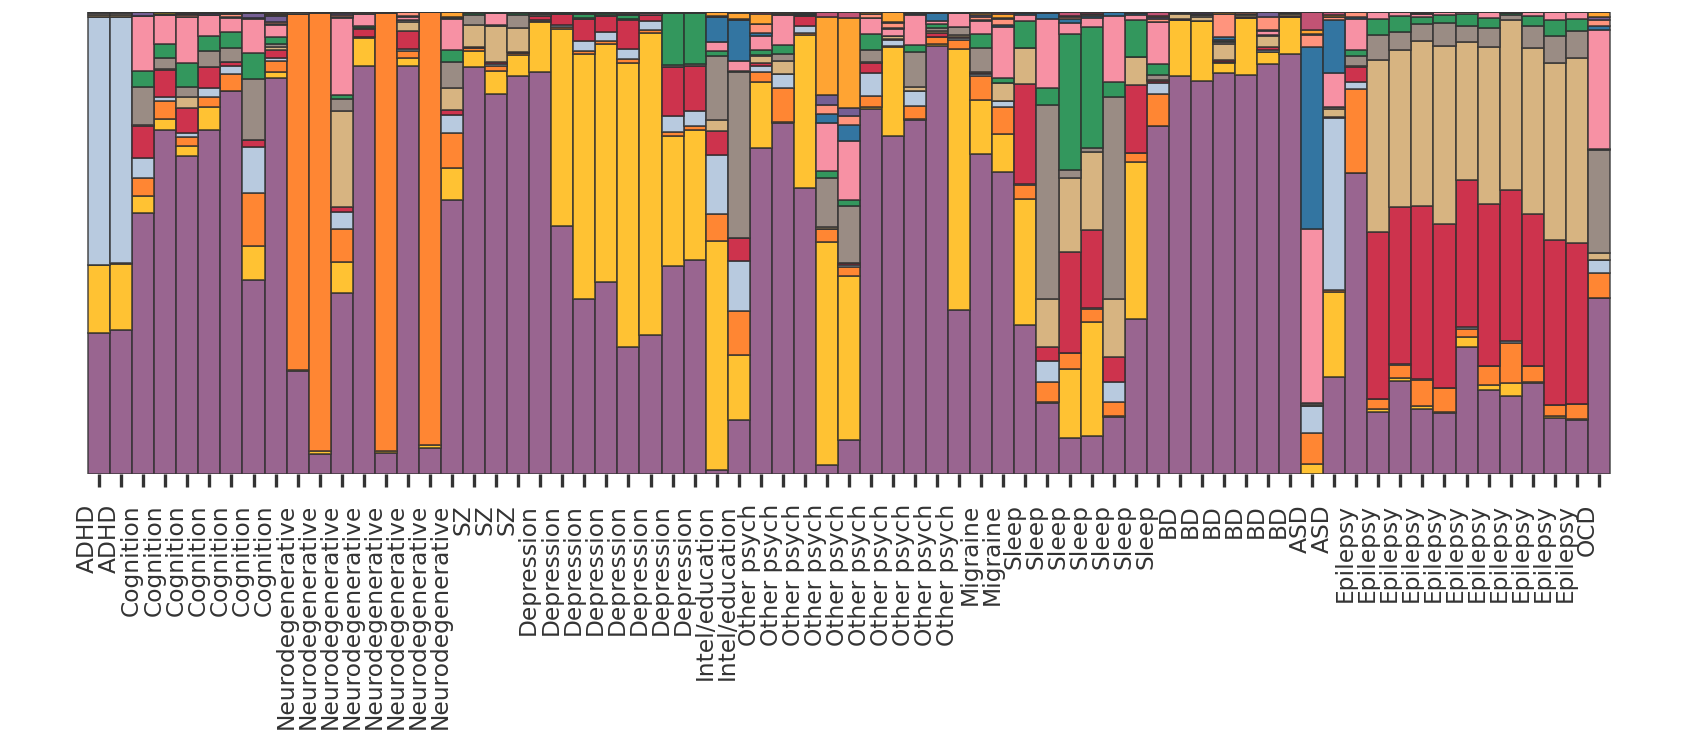

In [76]:
def get_cos2_scores(pcomps):
    ntrait, npcomp = pcomps.shape
    x = np.zeros((ntrait, npcomp))
    for i in range(ntrait):
        cos2_trait = np.array([np.square(pcomps[i, pcidx]) for pcidx in range(npcomp)])
        x[i, :] = cos2_trait / np.sum(cos2_trait)
    return x

def structure_plot(ax, data, xlabels, colors, bar_width = 1.0, alpha = 1.0):
    '''
    Parameters
    ----------
        data: 
            dict() of scores. 
            - <key> : items for the stacked bars (e.g. traits)
            - <value> : list of scores for the items. All dict entries must have the same length of <value>
        xlabels: 
            label for each entry in the data <value> list. Must be of same length of data <value>
        colors: 
            dict(<key>, <color>) corresponding to each data <key>.
    '''
    indices = np.arange(len(xlabels))
    bottom = np.zeros(len(xlabels))

    for item, weights in data.items():
        ax.bar(indices, weights, bar_width, label = item, bottom = bottom, color = colors[item], alpha = alpha)
        bottom += weights

    ax.set_xticks(indices)
    ax.set_xticklabels(xlabels, rotation=90, ha='right')

    for side, border in ax.spines.items():
        border.set_visible(False)

    ax.tick_params(bottom = True, top = False, left = False, right = False,
                   labelbottom = True, labeltop = False, labelleft = False, labelright = False)
    
    return


npcomp = 20
cos2_nnm = get_cos2_scores(pcomps_nnm_sparse)[:, :npcomp]

isorted = list()
for idx in trait_indices:
    isorted += list(idx)


xlabels = [labels[i] for i in isorted]
comp_colors  = {f"comp{i+1}": color for i, color in enumerate(mpl_stylesheet.kelly_colors()[:npcomp])}

cos2_plot_data = dict()
for i in range(npcomp):
    cos2_plot_data[f"comp{i+1}"] = cos2_nnm[isorted, i]

fig = plt.figure(figsize = (18, 5))
ax1 = fig.add_subplot(111)
#ax2 = fig.add_subplot(212)

structure_plot(ax1, cos2_plot_data, xlabels, comp_colors, alpha = 0.8)

In [ ]:

corr, _ = pearsonr(data1, data2)
print('Pearsons correlation: %.3f' % corr)

In [77]:
loadings.shape

(10068, 69)

In [81]:
from scipy.stats import pearsonr
def get_corr_matrix(X, pcomps, npcomp = 20):
    nvar = X.shape[1]
    corr = np.zeros((nvar, npcomp))
    for i in range(nvar):
        for pcidx in range(npcomp):
            d1 = X[:, i]
            d2 = pcomps[:, pcidx]
            corr[i, pcidx], _ = pearsonr(d1, d2)
    return corr

In [82]:
corr = get_corr_matrix(X_cent, pcomps_nnm_sparse)

In [86]:
corr[

array([[ 0.21639214, -0.20150224, -0.13907716, ...,  0.00732301,
        -0.03993463, -0.06978215],
       [-0.07484765,  0.08403886,  0.27069338, ...,  0.04693829,
        -0.00611539, -0.00879068],
       [-0.12384382,  0.00731024,  0.15212667, ...,  0.09556781,
        -0.05897277,  0.08014014],
       ...,
       [-0.00142332, -0.02666417,  0.03772111, ...,  0.25782807,
         0.22628517,  0.01785294],
       [-0.53966577, -0.43110921,  0.00210452, ...,  0.08255531,
        -0.01076185, -0.0661248 ],
       [ 0.52651817, -0.03643894, -0.18384033, ...,  0.08870578,
         0.00356767, -0.02190619]])

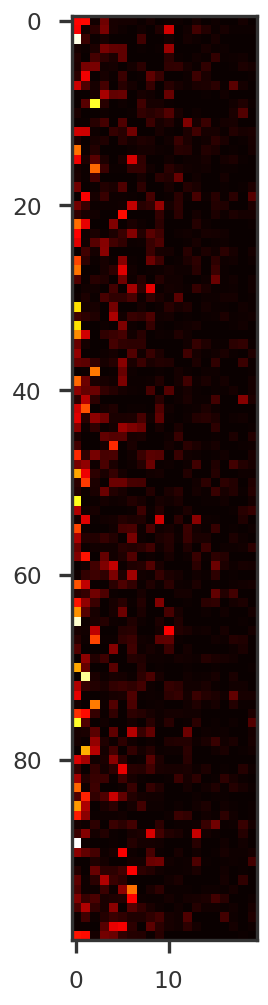

In [90]:
fig = plt.figure(figsize = (18, 10))
ax1 = fig.add_subplot(111)


ax1.imshow(np.square(corr[100:200, :]), cmap='hot', interpolation='nearest')

plt.show()

# Results

## Principal Components Biplots

Suppose, we decompose $\mathbf{X} = \mathbf{U}\mathbf{S}\mathbf{V}^{\intercal}$. 
Columns of $\mathbf{V}$ are the principal axes (aka principal directions, aka eigenvectors). 
The principal components are the columns of $\mathbf{U}\mathbf{S}$ -- the projections of the data on the the principal axes 
(note $\mathbf{X}\mathbf{V} = \mathbf{U}\mathbf{S}$).
We plot the principal components as a scatter plot and color each point based on their broad disease category.
To show the directions, we plot the loadings, $\mathbf{V}\mathbf{S}$ as arrows.
That is, the $(x, y)$ coordinates of an $i-$th arrow endpoint are given by the $i-$th value in the first and second column of $\mathbf{V}\mathbf{S}$.


[A comprehensive discussion of biplot on Stackoverflow](https://stats.stackexchange.com/a/141531)

In [18]:
def get_principal_components(X):
    X_cent = mpy_simulate.do_standardize(X, scale = False)
    X_cent /= np.sqrt(np.prod(X_cent.shape))
    U, S, Vt = np.linalg.svd(X_cent, full_matrices = False)
    pcomps = U @ np.diag(S)
    loadings = Vt.T @ np.diag(S)
    return loadings, pcomps

loadings_rpca,       pcomps_rpca = get_principal_components(rpca.L_)
loadings_nnm,        pcomps_nnm = get_principal_components(nnm.X)
loadings_nnm_sparse, pcomps_nnm_sparse = get_principal_components(nnm_sparse.X)

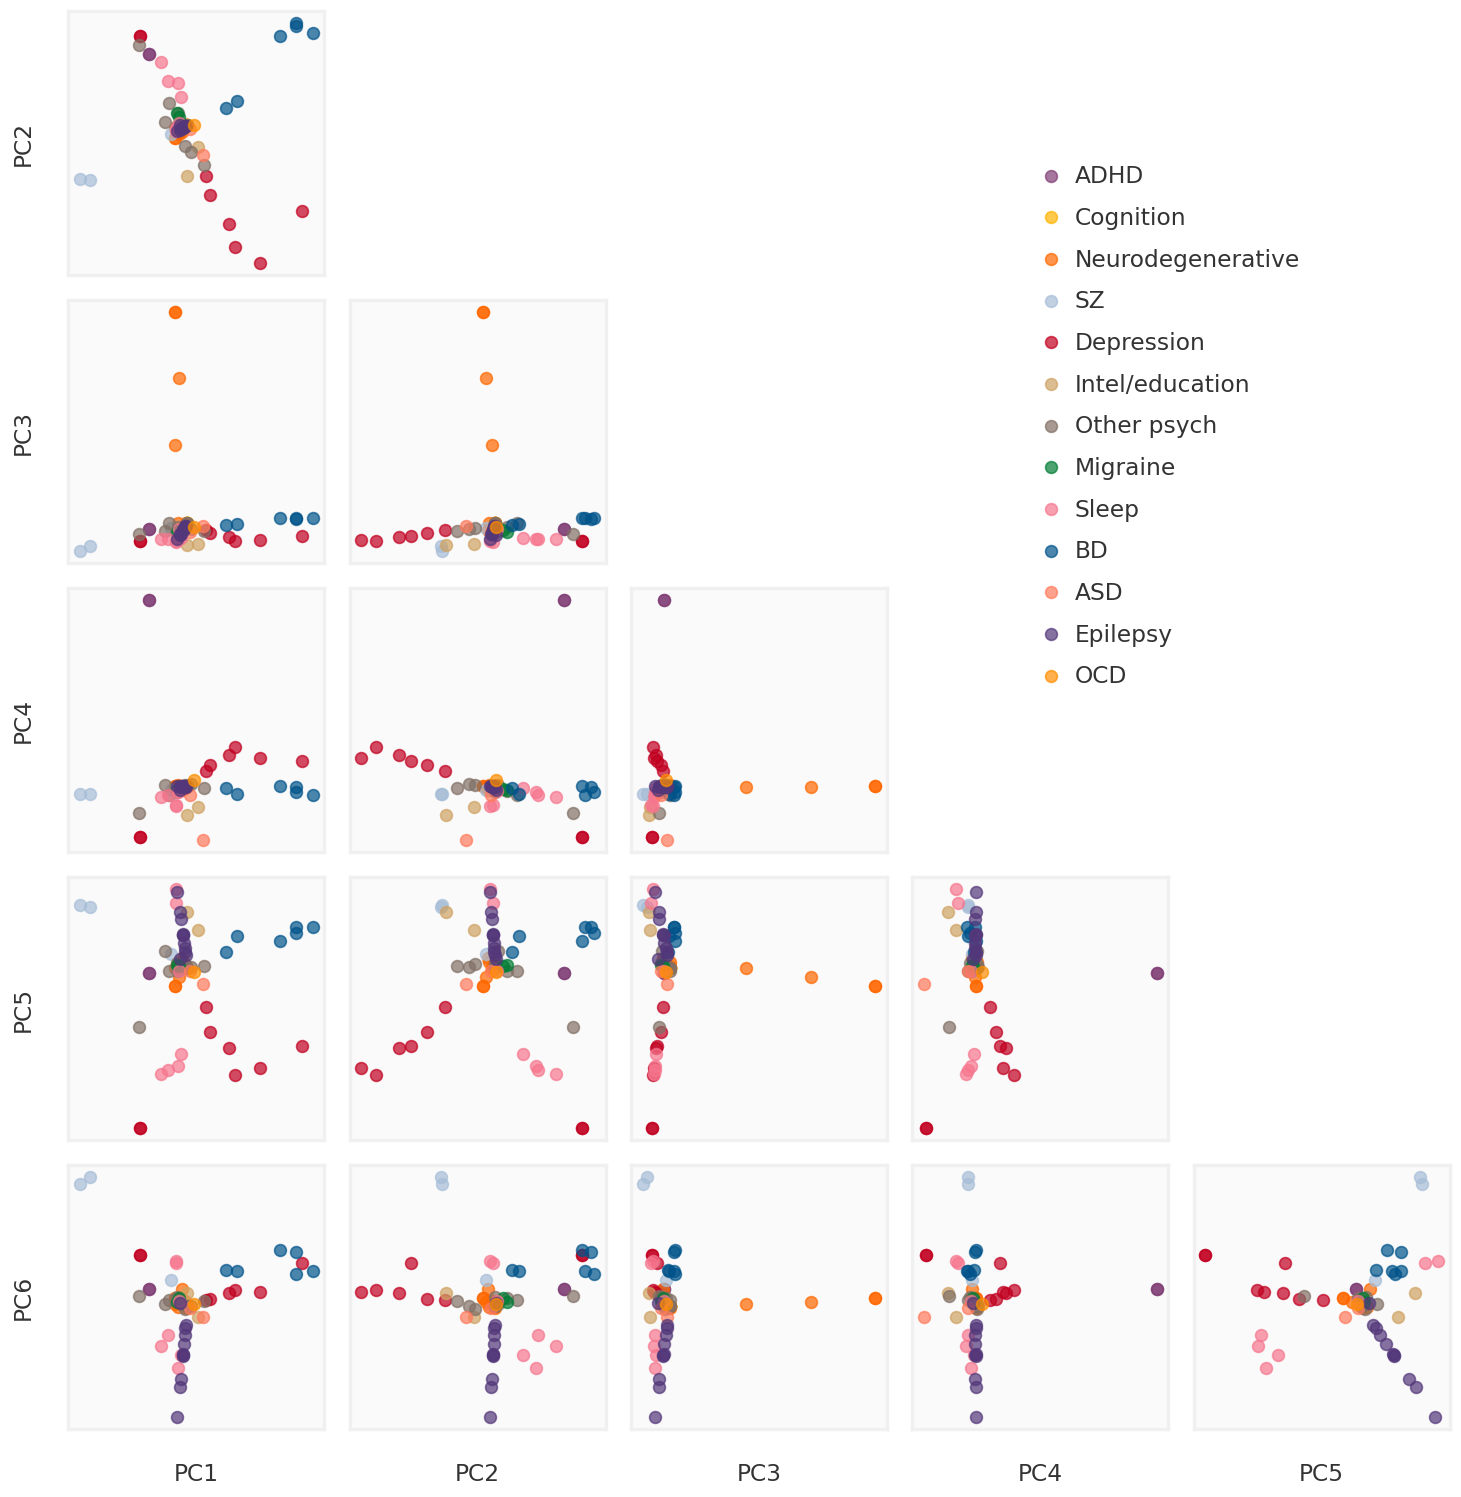

In [19]:
axmain, axs = mpy_plotfn.plot_principal_components(pcomps_rpca, labels, unique_labels)
plt.show()

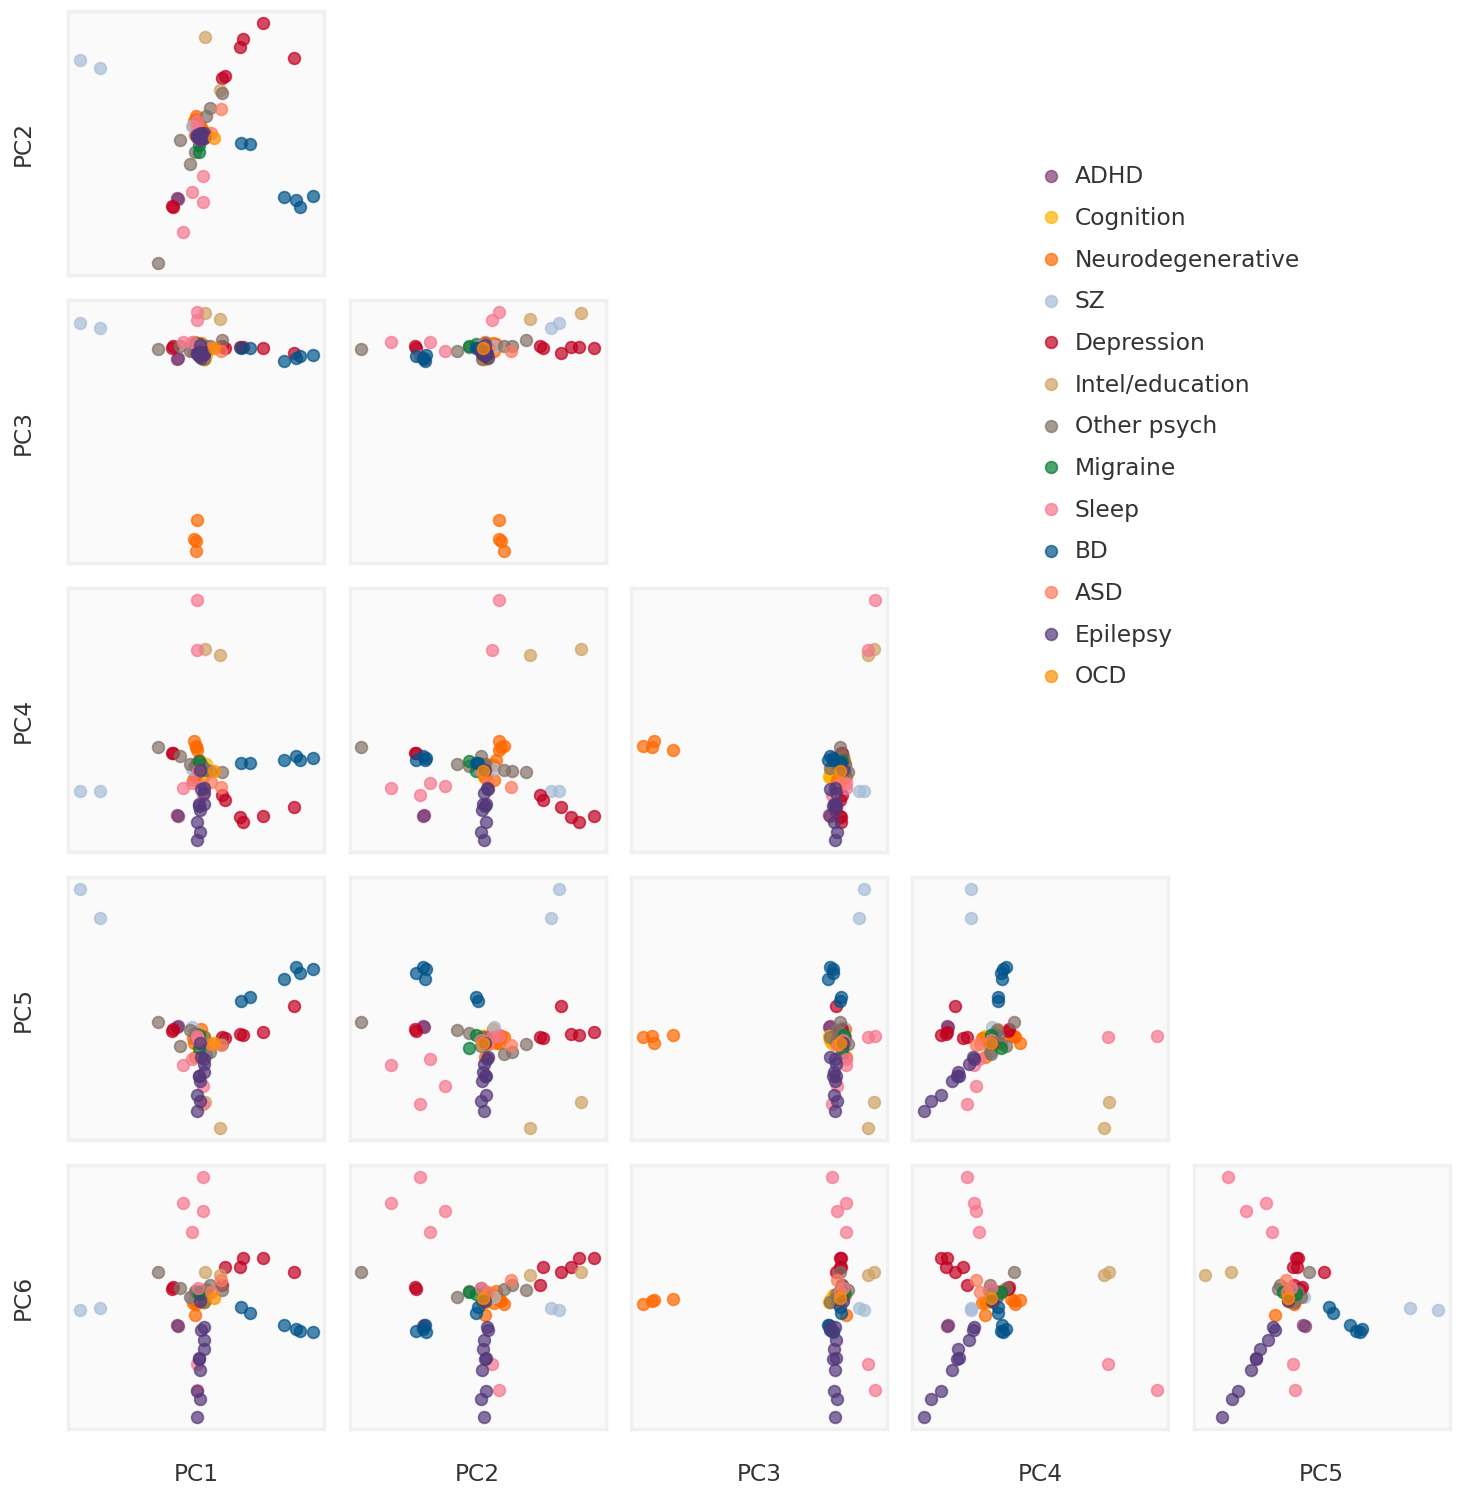

In [20]:
axmain, axs = mpy_plotfn.plot_principal_components(pcomps_nnm, labels, unique_labels)
plt.show()

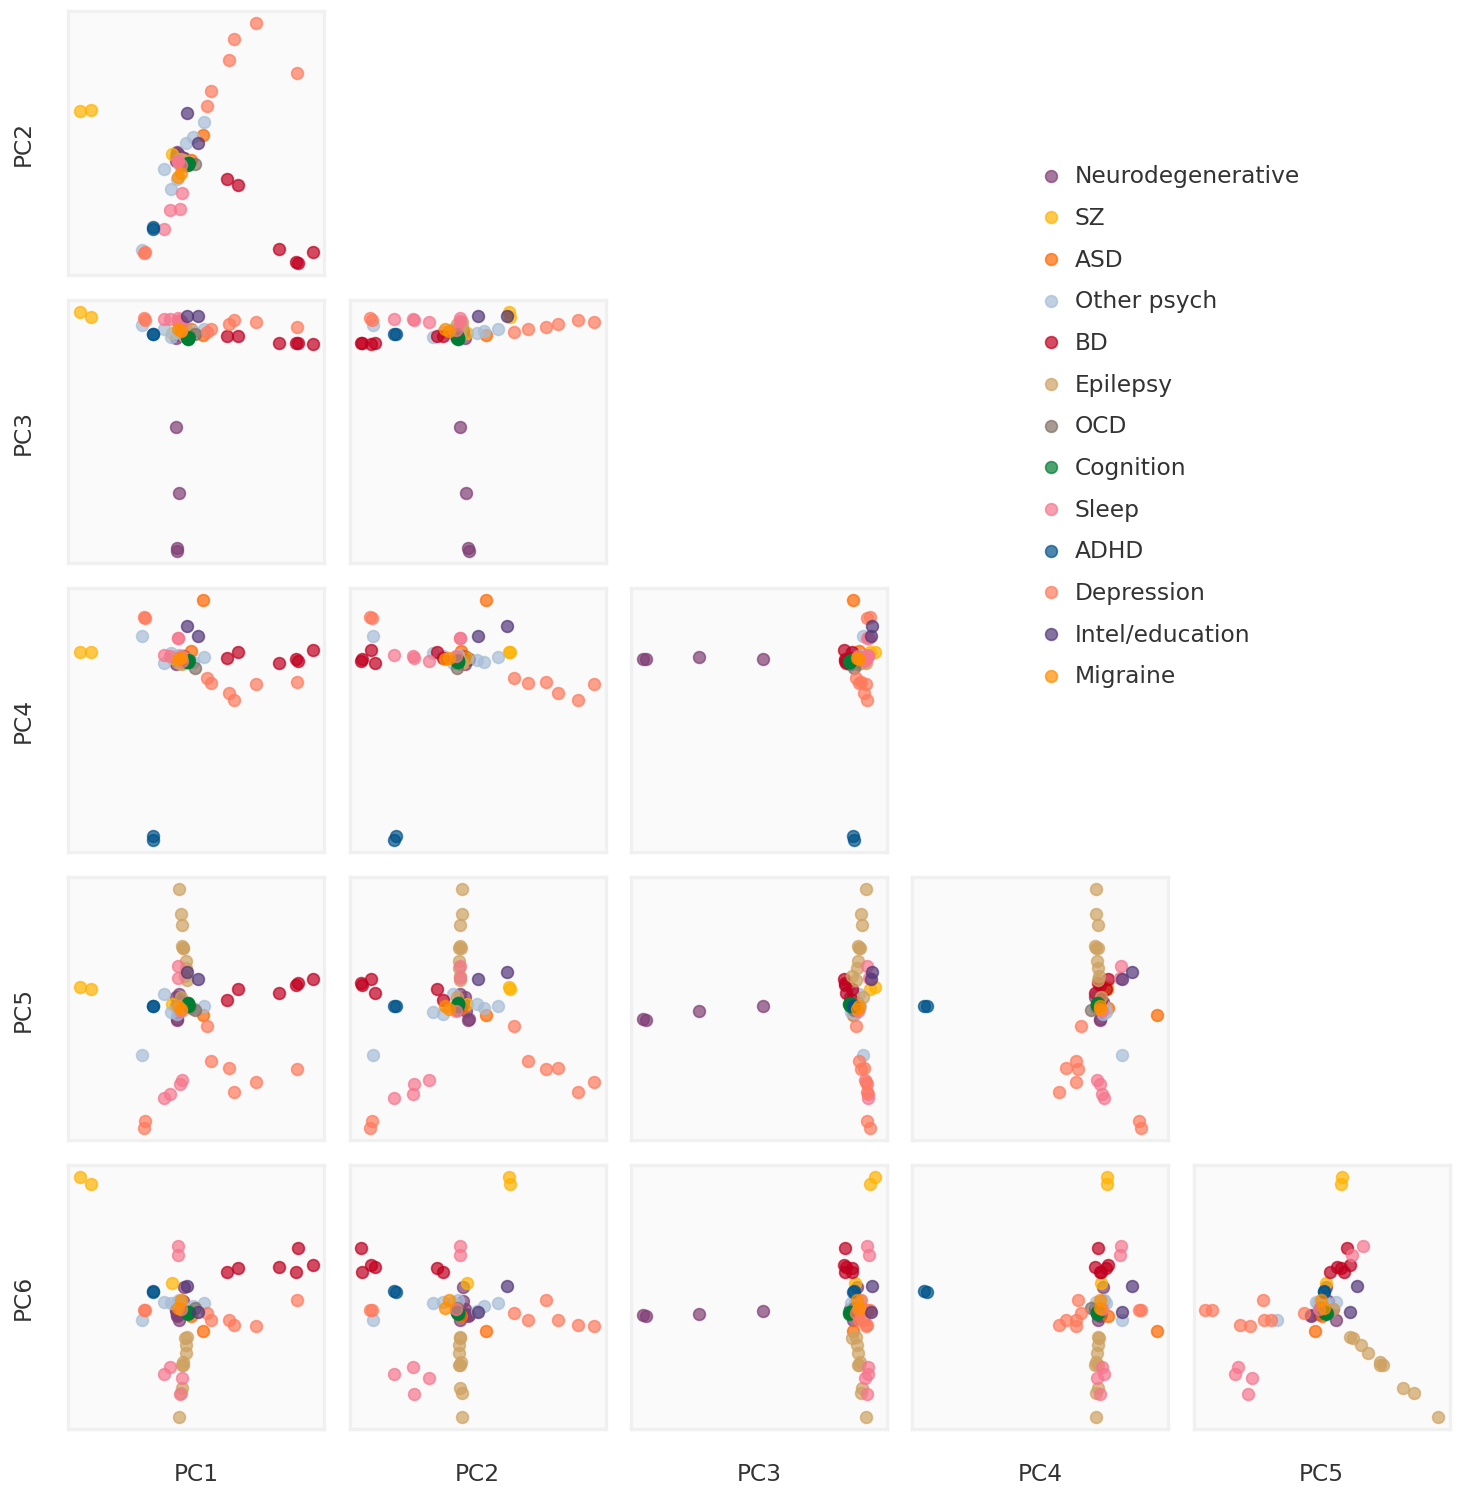

In [21]:
axmain, axs = mpy_plotfn.plot_principal_components(pcomps_nnm_sparse, labels, unique_labels)
plt.show()

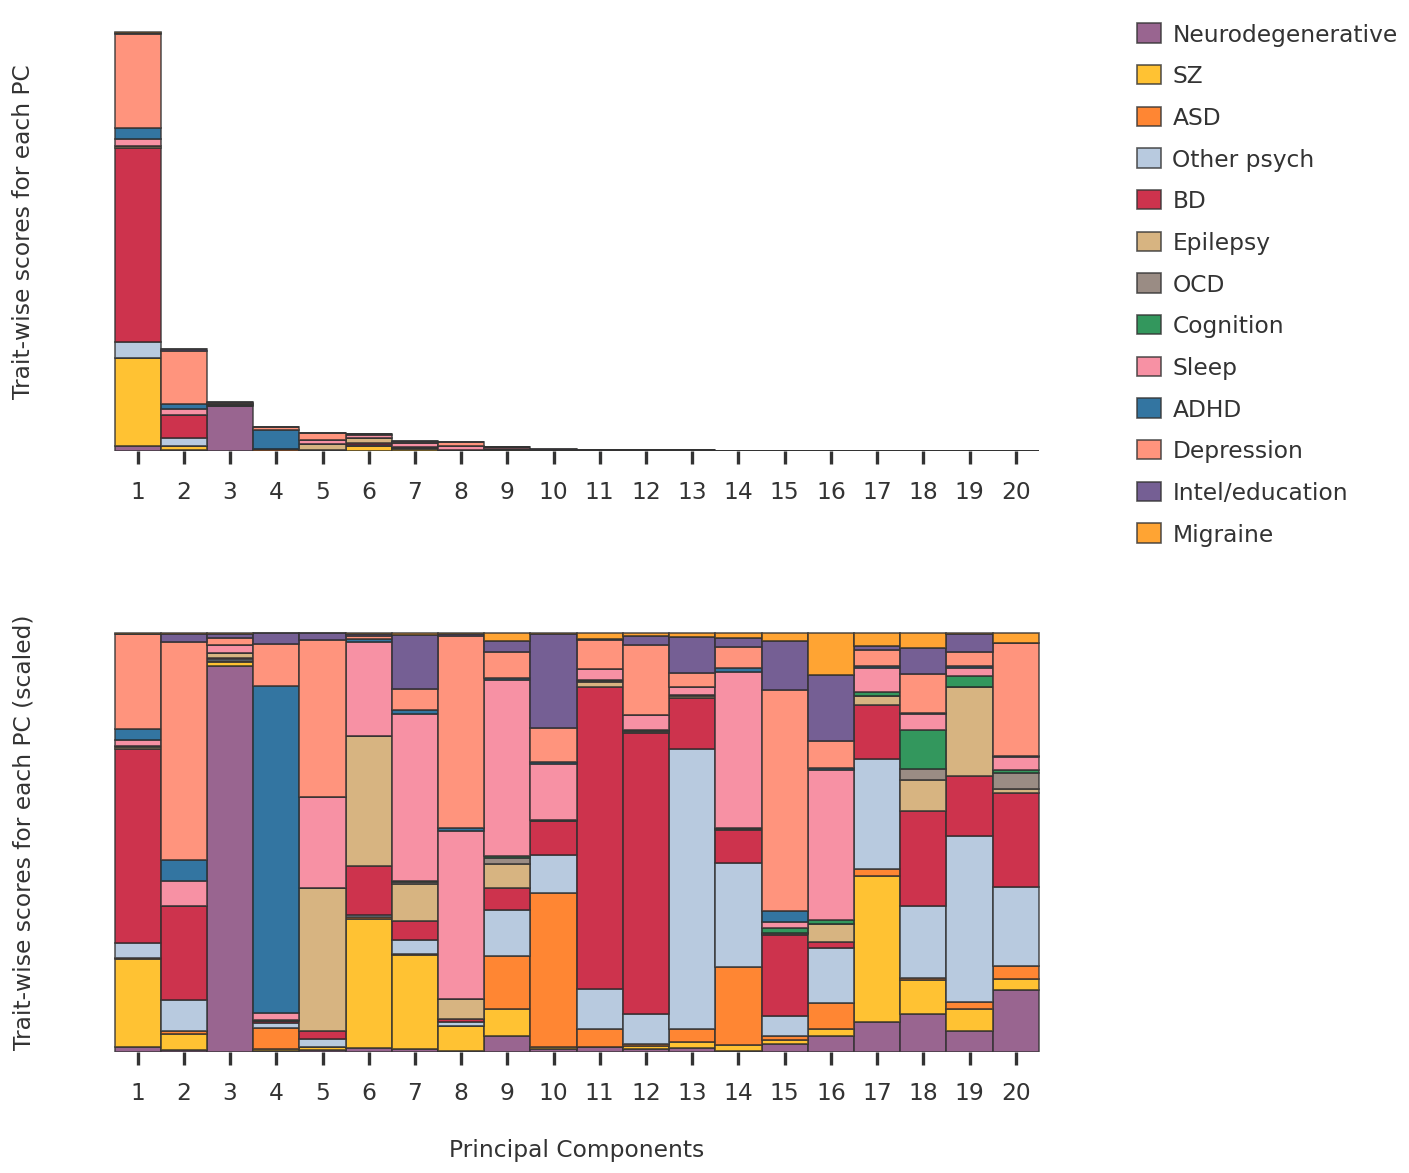

In [22]:
quick_plot_trait_pc_scores(nnm_sparse.X, trait_indices, unique_labels, trait_colors)

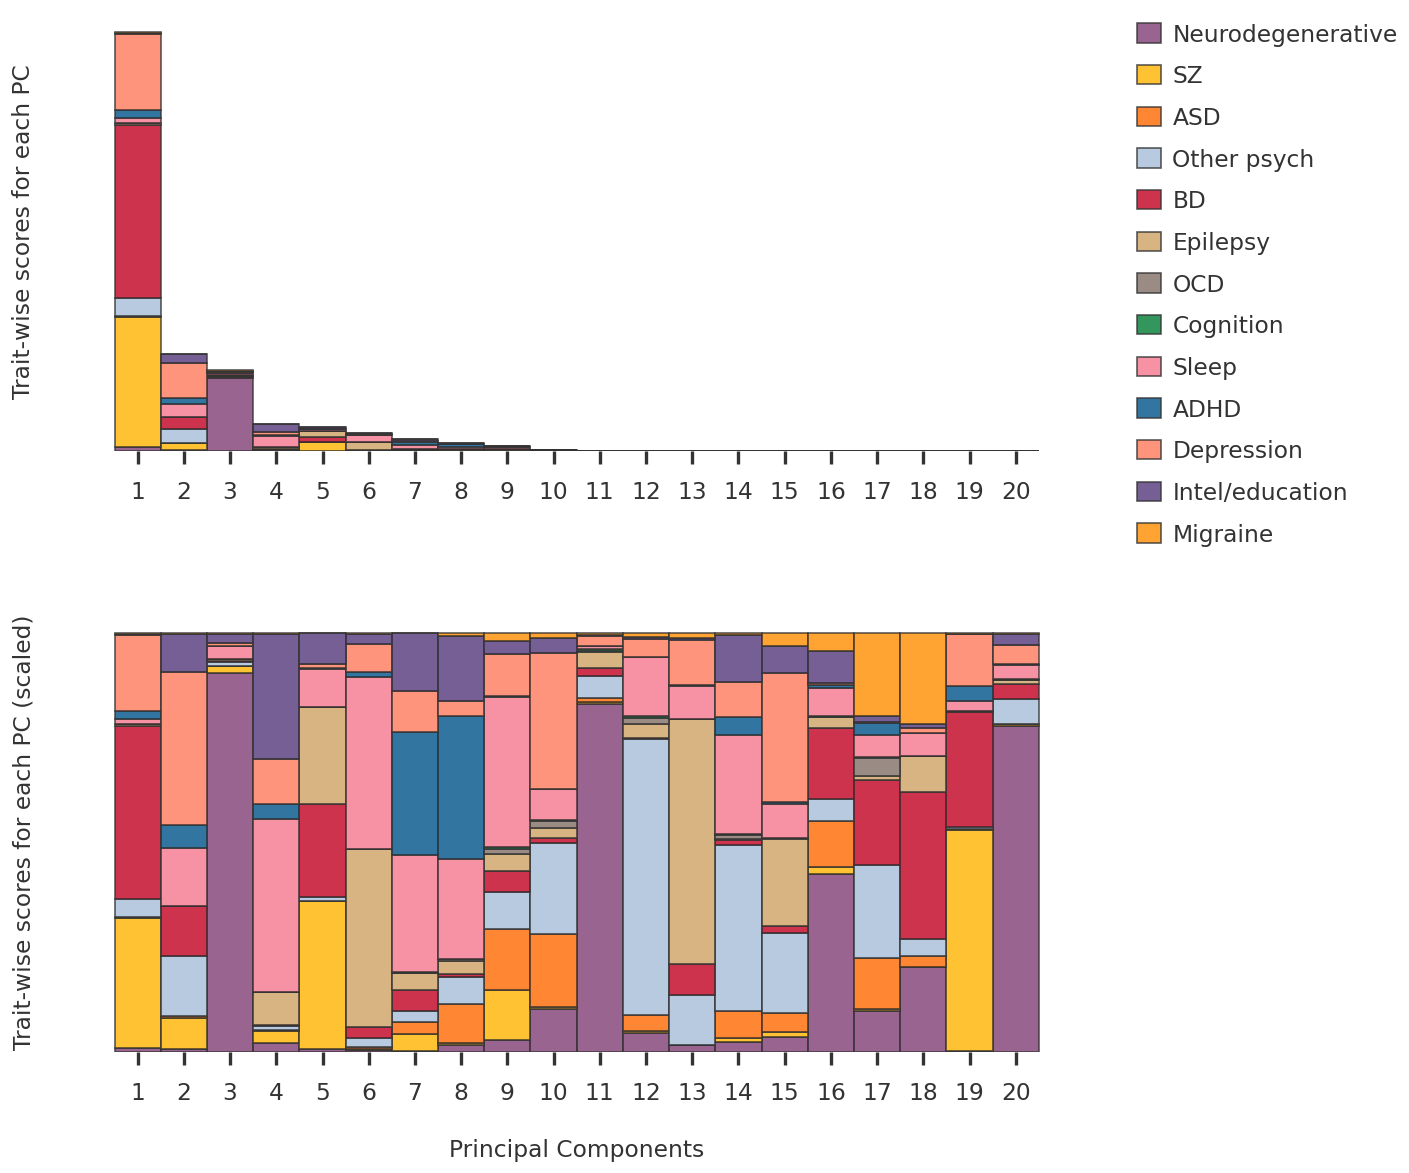

In [23]:
quick_plot_trait_pc_scores(nnm.X, trait_indices, unique_labels, trait_colors)

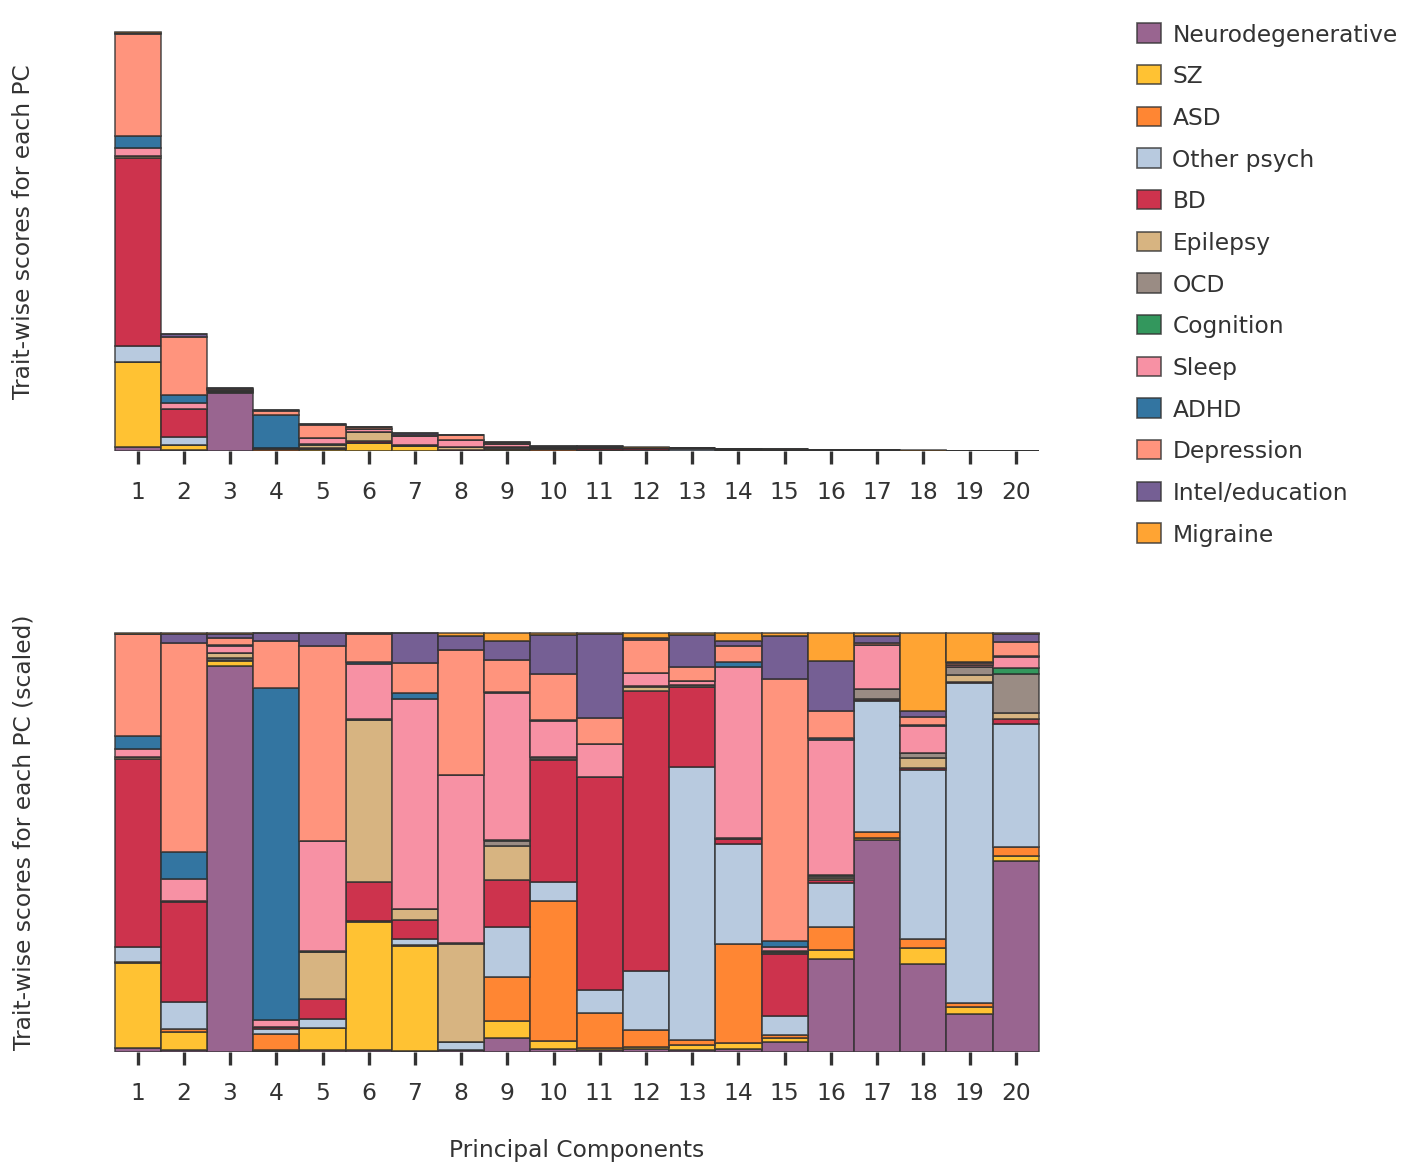

In [24]:
quick_plot_trait_pc_scores(rpca.L_, trait_indices, unique_labels, trait_colors)

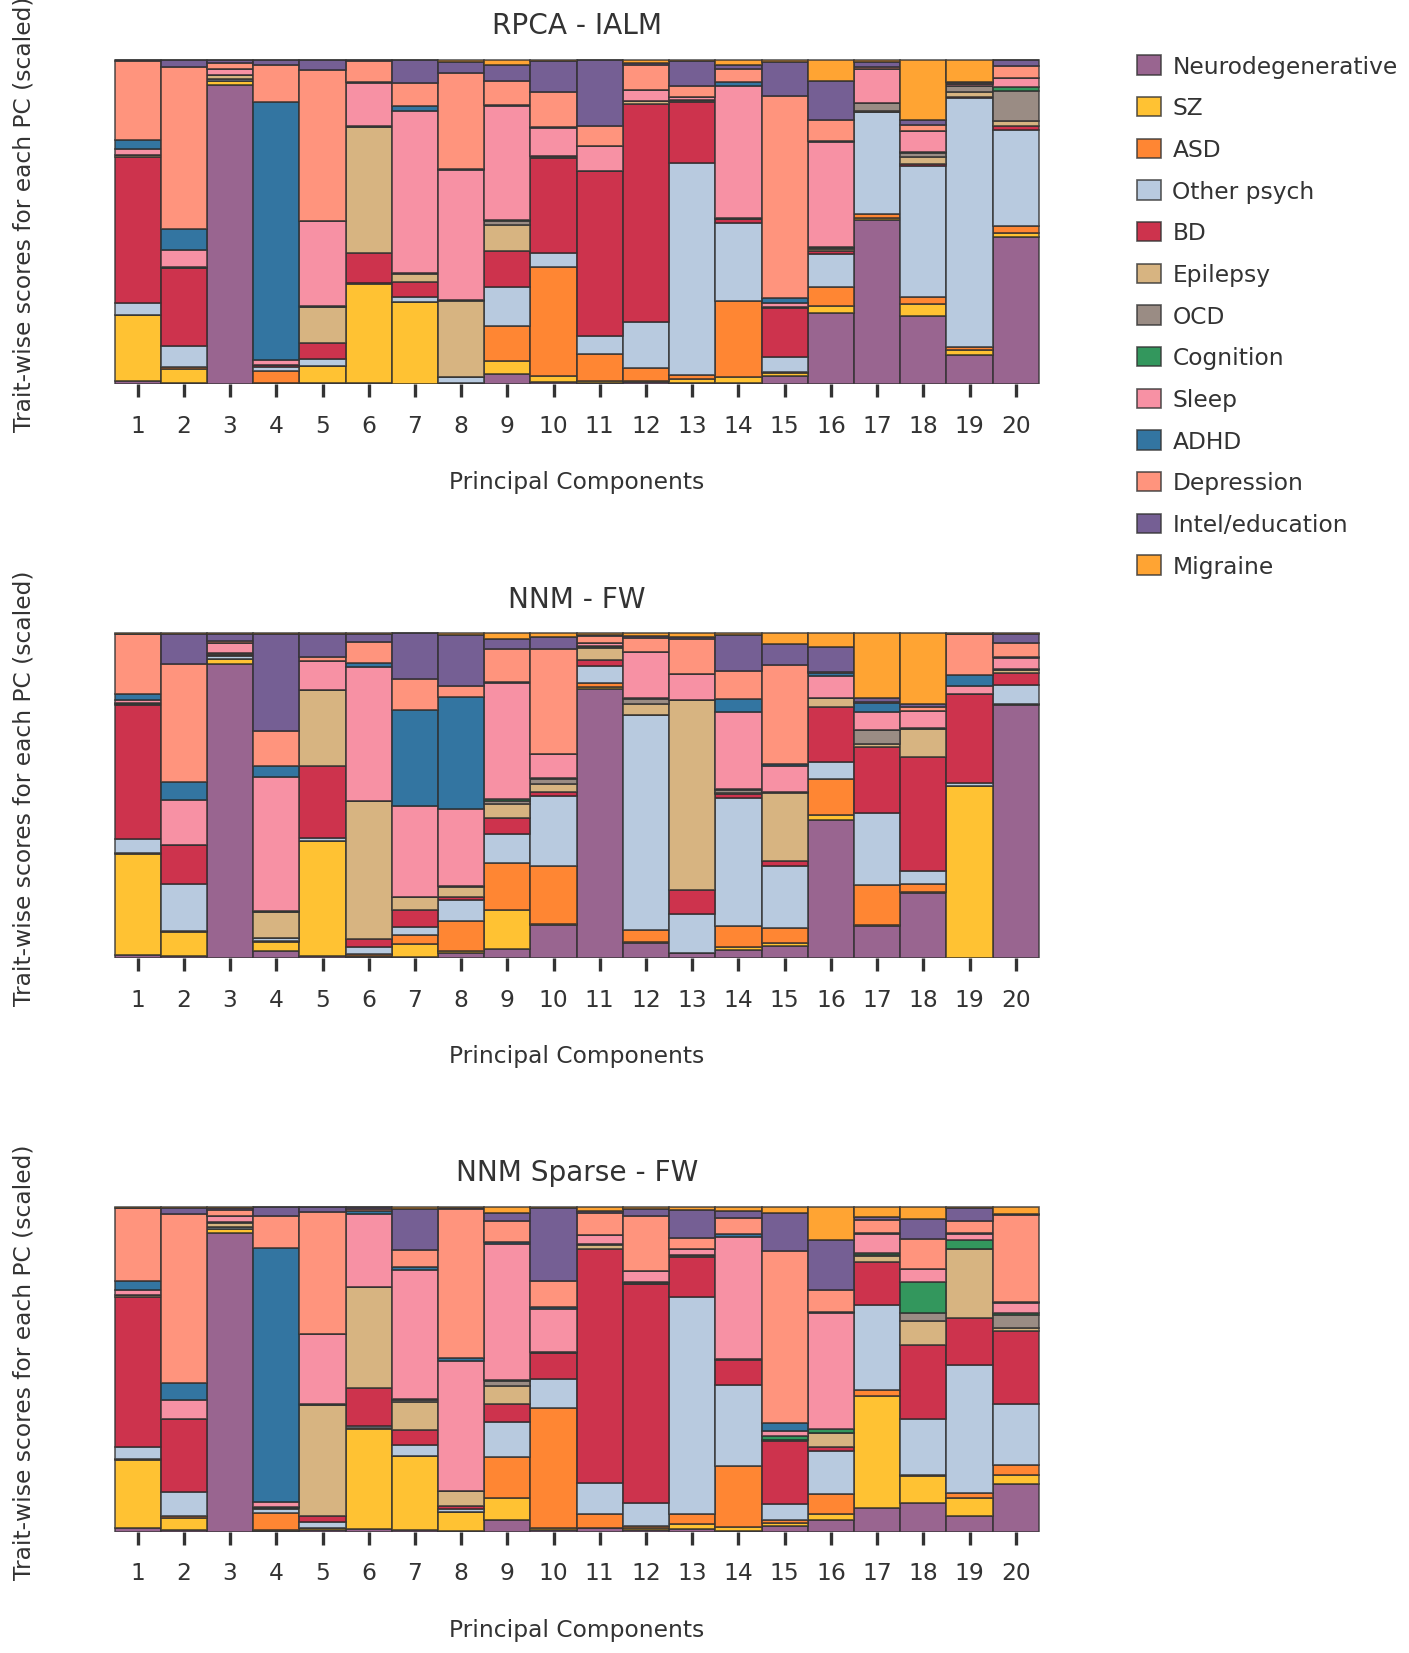

In [25]:
def quick_scale_plot_trait_pc_scores(ax, X, tindices, ulabels, tcolors, min_idx = 0, max_idx = 20):
    '''
    Quick helper function to plot the same thing many times
    '''
    X_cent = mpy_simulate.do_standardize(X, scale = False)
    U, S, Vt = np.linalg.svd(X_cent, full_matrices = False)
    
    #data = get_trait_pc_scores(U, S, tindices, ulabels, min_idx = min_idx, max_idx = max_idx, use_proportion = False)
    data_scaled = get_trait_pc_scores(U, S, tindices, ulabels, min_idx = min_idx, max_idx = max_idx, use_proportion = True)
    xlabels = [f"{i + 1}" for i in np.arange(min_idx, max_idx)]
    plot_stacked_bars(ax, data_scaled, xlabels, tcolors, alpha = 0.8)

    ax.set_xlabel("Principal Components")
    ax.set_ylabel("Trait-wise scores for each PC (scaled)")
    return

fig = plt.figure(figsize = (12, 14))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

quick_scale_plot_trait_pc_scores(ax1, rpca.L_, trait_indices, unique_labels, trait_colors)
quick_scale_plot_trait_pc_scores(ax2, nnm.X, trait_indices, unique_labels, trait_colors)
quick_scale_plot_trait_pc_scores(ax3, nnm_sparse.X, trait_indices, unique_labels, trait_colors)
ax1.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
ax1.set_title("RPCA - IALM")

ax2.set_title("NNM - FW")
ax3.set_title("NNM Sparse - FW")

plt.tight_layout(h_pad = 2.0)
plt.show()